In [15]:
from factor_tools import *

In [2]:
start_date = '2010-01-01'
end_date = '2021-01-31'
index_id = '000300.XSHG'

trade_month_list = get_period_date('M', start_date, end_date)
factor_pools = get_processed_cum_factor(trade_month_list, index_id)

In [3]:
univ = []
for date in trade_month_list:
    temp = get_index_univ(index_id, date)
    univ = list(set(univ + temp))
forward_return = get_forward_return(univ, trade_month_list, n=1)
forward_return = forward_return.pivot(index='date', columns='code', values='forward_return')

non_linear_size = factor_pools.pivot(index='date', columns='code', values='non_linear_size')
cfo_to_ev = factor_pools.pivot(index='date', columns='code', values='cfo_to_ev')
residual_volatility = factor_pools.pivot(index='date', columns='code', values='residual_volatility')
Skewness60 = factor_pools.pivot(index='date', columns='code', values='Skewness60')
Turnover60 = factor_pools.pivot(index='date', columns='code', values='Turnover60')
roe_ttm = factor_pools.pivot(index='date', columns='code', values='roe_ttm')
NNN = factor_pools.pivot(index='date', columns='code', values='NNN')
Skewness20 = factor_pools.pivot(index='date', columns='code', values='Skewness20')
gross_income_ratio = factor_pools.pivot(index='date', columns='code', values='gross_income_ratio')
pe_ratio = factor_pools.pivot(index='date', columns='code', values='pe_ratio')
pb_ratio = factor_pools.pivot(index='date', columns='code', values='pb_ratio')
inc_revenue_year_on_year = factor_pools.pivot(index='date', columns='code', values='inc_revenue_year_on_year')
inc_net_profit_year_on_year = factor_pools.pivot(index='date', columns='code', values='inc_net_profit_year_on_year')
inc_operation_profit_year_on_year = factor_pools.pivot(index='date', columns='code', values='inc_operation_profit_year_on_year')
sale_expense_to_operating_revenue = factor_pools.pivot(index='date', columns='code', values='sale_expense_to_operating_revenue')
PNN = factor_pools.pivot(index='date', columns='code', values='PNN')
RCGO = factor_pools.pivot(index='date', columns='code', values='RCGO')

In [10]:
fac_dict = {'经营活动产生的现金流量净额与企业价值之比TTM':cfo_to_ev,
                     '残差波动率':residual_volatility, 
                     '个股收益的60日偏度':Skewness60, 
                     '权益回报率TTM':roe_ttm,
                     '个股收益的20日偏度':Skewness20, 
                     '销售毛利率':gross_income_ratio, 
                     '市盈率（TTM）':pe_ratio, 
                     '市净率（TTM）':pb_ratio,
                     '单季度营业收入增长率（同比）':inc_revenue_year_on_year, 
                     '单季度净利润增长率（同比）':inc_net_profit_year_on_year,
                     '单季度营业利润增长率（同比）':inc_operation_profit_year_on_year,
                     '营业费用与营业总收入之比':sale_expense_to_operating_revenue,
                     'PNN':PNN,
                     'NNN':NNN,
                     '残差未实现收益':RCGO,
                     '60日平均换手率':Turnover60
                    }

fac_dict2 = { '经营活动产生的现金流量净额与企业价值之比TTM':cfo_to_ev,
                     '残差波动率':residual_volatility, 
                     '个股收益的60日偏度':Skewness60,  
                     '权益回报率TTM':roe_ttm, 
                     '个股收益的20日偏度':Skewness20, 
                     '销售毛利率':gross_income_ratio, 
                     '市盈率（TTM）':pe_ratio, 
                     '市净率（TTM）':pb_ratio,
                     '单季度营业收入增长率（同比）':inc_revenue_year_on_year, 
                     '单季度净利润增长率（同比）':inc_net_profit_year_on_year,
                     '单季度营业利润增长率（同比）':inc_operation_profit_year_on_year, 
                     '营业费用与营业总收入之比':sale_expense_to_operating_revenue,
                    }

In [11]:
eq_factor = equal_weight(fac_dict)
daily_returns = get_daily_return(univ, start_date, end_date)
daily_returns.index = pd.to_datetime(daily_returns.index)

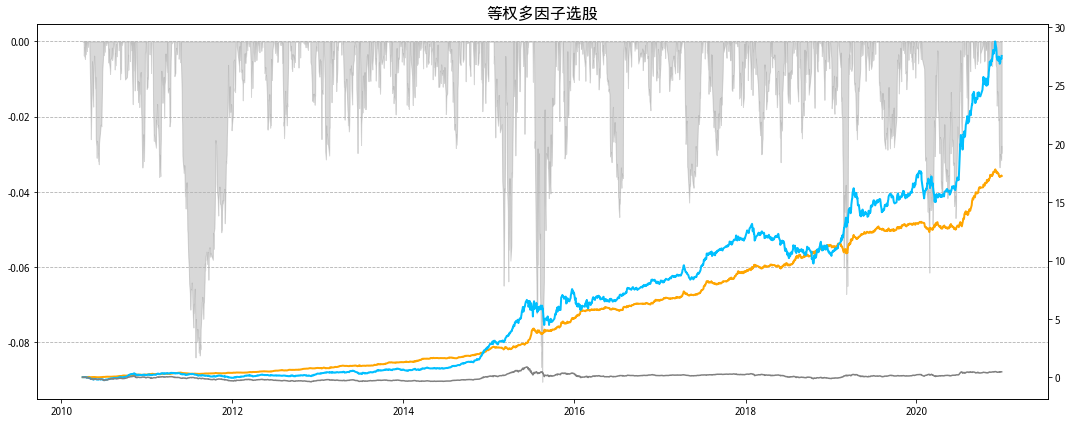

In [18]:
nav_df = easy_backtest(eq_factor,
                       eq_factor,
                        start_date='2010-01-01', 
                        end_date='2020-12-31',
                        daily_returns = daily_returns,
                        group=15, 
                    )

NA = net_value_analysis(nav_excess_df=nav_df)
NA.plot_hedging(title='等权多因子选股')
a = NA.cal_indicators()

In [19]:
a

,strategy,benchmark
年化收益率,34.87%,6.69%
年化标准差,23.60%,24.39%
贝塔,0.89,1
夏普比率,1.48,0.27
信息比率,2.97,0
最大回撤,32.26%,54.03%


In [10]:
def get_positions(factor, start_date, end_date, group=5, freq='M'):
    """
    获取持仓
    params：
        factor：dataframe，index为date，columns为code，values为因子值
        start_date：开始时间
        end_date：结束时间
        group：第几组作为持仓组合
        freq：调仓频率，默认月频，根据因子频率来设定
    return：
        nav_df：策略和基准的净值数据
    """
    rebalance_dates = get_period_date(freq, start_date, end_date)
    rebalance_dates = [datetime.strptime(dt, '%Y-%m-%d') for dt in rebalance_dates]
    factor.index = pd.to_datetime(factor.index)
    factor = factor.stack().dropna()
    factor.name = 'factor'
    
    quantile_groups = bucketize_by_quantile(factor, group)
    portfolio_weights = get_portfolios_from_quantile_groups(quantile_groups, group)
    
    cum_list = []
    for start in rebalance_dates:
        weights = portfolio_weights[start]
        dat = [start]*len(weights)
        weights = pd.DataFrame(weights)
        weights['date'] = dat
        weights = weights.reset_index()
        weights.columns = ['code', 'factor', 'date']
        cum_list.append(weights)
        
    cum_df = pd.concat(cum_list)
    cum_df = cum_df.reset_index().drop(['index'], axis=1)
    
    factors = []
    names = []
    
    for dat, cod in zip(cum_df.date, cum_df.code):
        factors.append(factor.loc[dat, cod])
        name = get_all_securities(date=dat)[['display_name']]
        names.append(name.display_name[cod])
    cum_df.factor = factors
    cum_df['name'] = names
    
    cum_df = cum_df.set_index(['date', 'code'])
    return cum_df

In [16]:
all_position = get_positions(eq_factor, start_date, '2020-12-31', group=12, freq='M')
file = 'eq_3_monthly.csv'
all_position.to_csv(file)

In [17]:
def get_latest_position(file, last_date=True, date='2020-01-23', num=50):
    """
    获取某一期的持仓
    param：
        file：持仓文件
        last_date：日期是否最新
        date：持仓日期
        num：持股数目
    return：
        某一期的持仓
    """
    position = pd.read_csv(file, index_col='date')
    
    date = position.index[-1]
    position = position.loc[date].nlargest(num,'factor')
    
    return position

In [18]:
get_latest_position(file, num=100)

,code,factor,name
date,,,
2020-12-31,002714.XSHE,12.648865,牧原股份
2020-12-31,600177.XSHG,11.359391,雅戈尔
2020-12-31,601881.XSHG,10.389175,中国银河
2020-12-31,601225.XSHG,10.226840,陕西煤业
2020-12-31,300142.XSHE,10.056373,沃森生物
2020-12-31,601155.XSHG,9.978429,新城控股
2020-12-31,601211.XSHG,9.314307,国泰君安
2020-12-31,002157.XSHE,9.085345,正邦科技
2020-12-31,600028.XSHG,8.947834,中国石化
